# From Data to a model

# Notebook 2 - (add theme here)

From now on we will import libraries that we already introduced in the first code cell of th notebook. In turn, this means you have to execute it in order for the rest to work properly

In [2]:
# Execute this cell to import all the libraries that we are going to use
# Once imported, you can then use them in every cell in this notebook. The same holds for 
# functions/classes you define or variables you declare (more on that mayne later) 


import matplotlib.pyplot as plt
# Settings for the figures
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")
from ipywidgets import interact

# The Leaky Integrate and fire model

Today we will expand upon the class we developed in the last sessions and incorporate the new features we learned in the lecture.
As a reminder, here is the differential equation that described the membrane potential of our neuron:

\begin{align}
\tau_m\,\frac{dV}{dt} &= - V + E_{L} + R_m\,I_e &\text{if }\quad V(t) \leq V_{th} \\ 
&&\\ 
V(t) &= V_{reset} &\text{otherwise}
\end{align}


where $V$ is the membrane potential, $\tau_m$ is the membrane time constant, $E_{L}$ is the leak potential, $R_m$ is the membrane resistance, $I_e$ is the synaptic input current, $V_{th}$ is the firing threshold, and $V_{reset}$ is the reset voltage.

#### Adding Synaptic inputs
We now want to include synaptic input to our model. One excitatory input (AMPA) and one inhibitory input (GABA A).
As discussed in the lecture we can add the membrane currents in the following fashion:

\begin{align}
\frac{dV}{dt} &= \left(- V + E_{L} + R_m\,I_e  -i_{ampa} - i_{gaba}\right)/\tau_m\ &\text{if }\quad V(t) \leq V_{th} \\ 
\\ 
V(t) &= V_{reset} &\text{otherwise}
\end{align}


The task is to add the syanptic inputs to our class from the previous notebook. We <b>first start with the excitatory input $i_{ampa}$</b>, it follows the same logic as the inhibitory one - adding $i_{gaba}$ is therefore rather straightorward afterwards.

There are a couple of things we want to add now, let's break it down step by step: 

1) We need to consider the equation for synaptic inputs, from the lecture we know that we can fit the excitatory postsynaptic current with an exponential function because $P(s) \propto e^{-\frac{t}{\tau_{ampa}}}$. we already know another implementation of an exponential decay (the voltage membrane) so we use the same principle for the channel open probaility:

\begin{equation}
\frac{dP_s}{dt} = - P_s/\tau_{AMPA}
\end{equation}

This is our time evolution of the channel open probability. We need to add this to the 'timestep' function of our class, in the same way as we update the membrane evolution.

2) when the presynaptic neuron fires, we need to open all channels (in reality there is a small delay, but we model the opening of channels as an intermediate event. In formulas this means we want to set our channel open probability to one:

so given the condition of a presynaptic event we want to set:

\begin{equation}
P_s = 1 \qquad \qquad\text{if presynaptic spike}
\end{equation}

\begin{align}
\frac{d\,P_s}{d\,t} = - P_s/\tau_{AMPA}
\end{algin}

3) We actually need to define all those variables when we initiate the class (so in the 'init' method of our class. The parameters are:

\begin{equation}

\end{equation}


<details>
    <summary><font color="red"><b>click here to show/hide class code</b></font></summary>

```python
class LIFNeuron(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_start = -50, el = -75, r_m = 100e6, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = el # leak reversal potential
        
        self.r_m = r_m # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = v_start # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [v_start]
        self.t_list = [0]
        
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        for ii in range(time_steps):
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])
```

</details>

We now want to have a look at the different integration methods. We have seen two in the lecture: 

The euler method and Runge Kutta 4. 

We already use the euler method and now want to add the ability to run our simulation either with the euler or the Runge Kutta 4 method. 
There are manz solutions to this problem. 
One possible way is to add two new methods to the class:
```python
    def dv_dt_euler( 
```

<details>
    <summary><font color="red"><b>Show equations</b></font></summary>
\begin{equation}
\begin{aligned}
F(V,t) = \frac{dV}{dt} &= \left(- V + E_{L} + R_m\,I_e \right)/\tau_m\\ 
h &= \Delta t
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
&&k_1=F\left(t_i, S\left(t_i\right)\right) \\
    &&k_2=F\left(t_i+\frac{h}{2}, S\left(t_i\right)+\frac{1}{2} k_1 h\right) \\
    &&k_3=F\left(t_i+\frac{h}{2}, S\left(t_i\right)+\frac{1}{2} k_2 h\right) \\
&&k_4=F\left(t_i+h, S\left(t_i\right)+k_3 h\right)
\end{aligned}
\end{equation}
    

### <font color="blue"><b>Runge Kutta 4</b></font>

    
\begin{equation}
\begin{aligned}
&S\left(t_{i+1}\right) = S\left(t_i\right) + \frac{h}{6}\left(k_1 + 2\,k_2 + 2\, k_3 + k_4\right)&
\end{aligned}
\end{equation}
    
    
### <font color="blue"><b>Euler</b></font>

\begin{equation}
\begin{aligned}
&S\left(t_{i+1}\right) = S\left(t_i\right) + k_1 * h&\\
\end{aligned}
\end{equation}

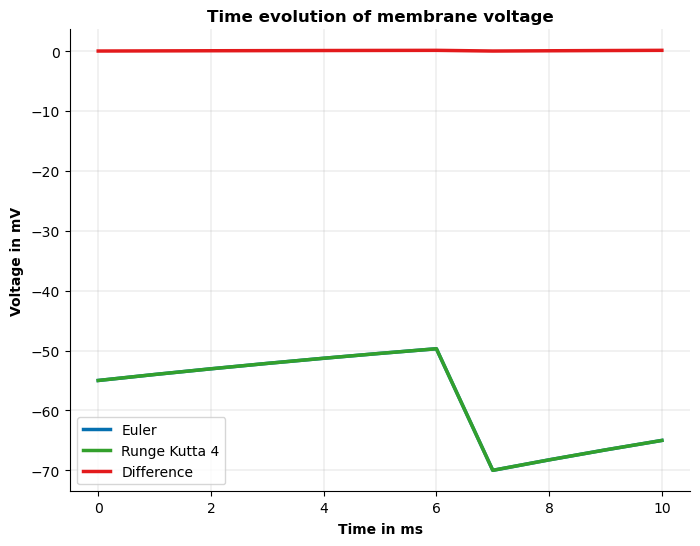

In [50]:
class LIFNeuron(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 20, v_start = -55, el = -75, r_m = 100e6, v_reset = -70, v_th = -50,
                 I_e = 10e-8,
                 dt = 0.1,
                 integration_method = 'euler'):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()
        self.tau_m = tau_m
        self.el = el
        self.dt = dt
        self.r_m = r_m
        self.v_reset = v_reset
        self.v_th = v_th

        self.v = v_start

        self.I_e = I_e

        self.v_list = [v_start]
        self.t_list = [0]
        
        self.integration_method = integration_method

    
    def dv_dt(self, v): # new
        return (-v + self.el)/self.tau_m + self.r_m * self.I_e # new
        
    def timestep(self):
        if self.v <= self.v_th:
            dv_dt_1 = self.dv_dt(self.v) # new
            
            if self.integration_method == 'euler': # new
                self.v += dv_dt_1 * self.dt
                return
            
            if self.integration_method == 'rk4': # new
                dv_dt_2 = self.dv_dt(self.v + dv_dt_1*self.dt/2.)
                dv_dt_3 = self.dv_dt(self.v + dv_dt_2*self.dt/2.)
                dv_dt_4 = self.dv_dt(self.v + dv_dt_3*self.dt)
                self.v += self.dt/6 * (dv_dt_1 + dv_dt_2 * 2+ dv_dt_3 * 2 + dv_dt_4)
        else:
            self.v = self.v_reset


    def run_simulation(self, time_steps = 100):

        for ii in range(time_steps):
            self.timestep()
            current_time = self.t_list[-1] + self.dt
            
            
            
            self.v_list.append(self.v)
            
            self.t_list.append(current_time) 

    def plot_traces(self):

        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])
        

factor = 10000

dt = 1
time_steps = 10

neuron_compare = LIFNeuron(I_e = 2e-8,dt=dt/factor, integration_method='euler')
neuron_euler =   LIFNeuron(I_e = 2e-8,dt=dt       , integration_method='euler')
neuron_rk4 =     LIFNeuron(I_e = 2e-8,dt=dt       , integration_method='rk4')

neuron_compare.run_simulation(time_steps = time_steps*factor)
neuron_euler.run_simulation  (time_steps = time_steps)
neuron_rk4.run_simulation    (time_steps = time_steps)

plt.figure()
plt.title('Time evolution of membrane voltage')

# plt.plot(neuron_compare.t_list,neuron_compare.v_list,linewidth=2.5, label='Euler')
plt.plot(neuron_euler.t_list,neuron_euler.v_list,linewidth=2.5, label='Euler')
plt.plot(neuron_rk4.t_list,neuron_euler.v_list,linewidth=2.5, label='Runge Kutta 4')
# plt.plot(neuron_rk4.t_list,np.array(neuron_compare.v_list)[::factor]-np.array(neuron_euler.v_list),linewidth=2.5, label='Runge Kutta 4')
# plt.plot(neuron_rk4.t_list,np.array(neuron_compare.v_list)[::factor]-np.array(neuron_rk4.v_list),linewidth=2.5, label='Runge Kutta 4')
plt.plot(neuron_rk4.t_list,np.array(neuron_euler.v_list)-np.array(neuron_rk4.v_list),linewidth=2.5, label='Difference')
plt.xlabel('Time in ms')
plt.ylabel('Voltage in mV')

# plt.ylim([-80,20])
plt.legend()

In [3]:
class LIFNeuron(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_start = -50, el = -75, r_m = 100e6, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = el # leak reversal potential
        
        self.r_m = r_m # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = v_start # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [v_start]
        self.t_list = [0]
        
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        for ii in range(time_steps):
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

In [ ]:
import numpy as np
from ipywidgets import interact

<pre><code>
def main():
    __config_bash
    <mark>__config_xdg_dirs</mark>
    
</code></pre>

In [18]:
def main():
    __config_bash
    __config_xdg_dirs

In [28]:
class LIFNeuron_AMPA(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_start = -50, el = -75, r_m = 100e6, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 100):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron_AMPA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = el # leak reversal potential
        
        self.r_m = r_m # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = v_start # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [v_start]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''            
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        ### Time evolution of the membrane potential
        if self.v <= self.v_th:
            i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        for ii in range(time_steps):
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

        
def run_and_plot(I_e, d_T):
    test = LIFNeuron_AMPA(I_e = I_e*1e-8, g_ampa = 0.85)
    test.run_simulation(1000)
    test.ampa_input = True
    test.run_simulation(10 + d_T)
    test.ampa_input = True
    test.run_simulation(10 + d_T)
    test.ampa_input = True
    test.run_simulation(10 + d_T)
    test.ampa_input = True
    test.run_simulation(10 + d_T)
    test.ampa_input = True
    test.run_simulation(1000)
    test.plot_traces()

interact(run_and_plot, I_e = (0,10,1),d_T=(0,1000,100))

interactive(children=(IntSlider(value=5, description='I_e', max=10), IntSlider(value=500, description='d_T', m…

<function __main__.run_and_plot(I_e, d_T)>

In [3]:
class LIFNeuron_AMPA_GABA(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_start = -50, el = -75, r_m = 100e6, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 100, g_gaba = 100):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron_AMPA_GABA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = el # leak reversal potential
        
        self.r_m = r_m # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = v_start # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [v_start]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt
            
        ### Time evolution of the membrane potential
        if self.v <= self.v_th:
            i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
            i_gaba = self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa + i_gaba)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, 
                       time_steps = 100,
                       ampa_inputs = [],
                       gaba_inputs = []):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
            We can define synaptic events as time_steps in a list.
            either exitatory (ampa_inputs) or inhibitory (gaba_inputs)
        '''
        
        for ii in range(time_steps):
            
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                self.ampa_input = True
            
            if ii in gaba_inputs:
                self.gaba_input = True
            
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])
    

        
def run_and_plot(I_e, gaba_input_timestep):
    test = LIFNeuron_AMPA_GABA(I_e = I_e*1e-8, g_ampa = 0.85, g_gaba = 0.8)
    test.run_simulation(2000, 
                        ampa_inputs = [1000, 1050, 1100],
                       gaba_inputs = [gaba_input_timestep],
                       )
    test.plot_traces()
    
    
    # reading out the time and voltage value so that the arrow points to the plot
    # If you don't know how to access an element in the list, feel free to ask
    x_input = test.t_list[gaba_input_timestep] 
    y_input = test.v_list[gaba_input_timestep]
    
    # use the annotate function to plot an arrow and the text 'GABA input'
    plt.annotate('GABA input', xy =(x_input, y_input),
                xytext =(x_input-40, y_input + 20), 
                arrowprops = dict(arrowstyle='->',facecolor ='#CC1414', edgecolor='#CC1414',
                                  shrinkA = 0.1))

interact(run_and_plot,I_e = 5, gaba_input_timestep=(700,1150,10))

interactive(children=(IntSlider(value=5, description='I_e', max=15, min=-5), IntSlider(value=920, description=…

<function __main__.run_and_plot(I_e, gaba_input_timestep)>

In [37]:
class LIFComp_AMPA_GABA(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_start = -50, el = -75, r_m = 100e6, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.9, g_gaba = 0.9,
                 g_end_a = 0.5, g_end_b = 0.5,
                 can_spike = True):
        '''This function is executed when we create an object from that class'''
        super(LIFComp_AMPA_GABA, self).__init__()
        
        self.can_spike = can_spike
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = el # leak reversal potential
        
        self.r_m = r_m # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = v_start # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [v_start]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        
        
        ### Initiate neighbour parameters
        self.v_end_a = v_start
        self.v_end_b = v_start
        self.g_end_a = g_end_a
        self.g_end_b = g_end_b
        
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt
            
        ### Time evolution of the membrane potential
        if self.v <= self.v_th or not self.can_spike:
            i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
            i_gaba = self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)
            i_end_a = self.g_end_a * (self.v_end_a - self.v)
            i_end_b = self.g_end_b * (self.v_end_b - self.v)
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa + i_gaba + i_end_a + i_end_b)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, 
                       time_steps = 100,
                       ampa_inputs = [],
                       gaba_inputs = []):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
            We can define synaptic events as time_steps in a list.
            either exitatory (ampa_inputs) or inhibitory (gaba_inputs)
        '''
        
        for ii in range(time_steps):
            
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                self.ampa_input = True
            
            if ii in gaba_inputs:
                self.gaba_input = True
            
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            

In [75]:

# create the neuron

def construct_and_run_multicompartment(delta_inputs = 100, g_ampa = 0.8, g_couple = 0.8, n_inputs = 4):
    # first the soma
    soma = LIFComp_AMPA_GABA(g_end_a = 0, g_end_b = g_couple, can_spike=True, v_start=-65, g_ampa = g_ampa)
    dend_1 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = g_couple, can_spike=False, v_start=-65, g_ampa = g_ampa)
    dend_2 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = g_couple, can_spike=False, v_start=-65, g_ampa = g_ampa)
    dend_3 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = g_couple, can_spike=False, v_start=-65, g_ampa = g_ampa)
    dend_4 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = 0, can_spike=False, v_start=-65, g_ampa = g_ampa)

    all_compartments = [soma, dend_1, dend_2, dend_3, dend_4]

    # now we run the simulation
    for ii in range(1200):


        # we transfer every neighbouring voltage
        for jj, comp in enumerate(all_compartments):

            aa = jj - 1
            bb = jj + 1

            if aa >= 0:
                comp_a = all_compartments[aa]
                comp.v_end_a = comp_a.v

            if bb <= len(all_compartments) - 1:
                comp_b = all_compartments[bb]
                comp.v_end_b = comp_b.v

        # now we run one timestep for every compartment
        for comp in all_compartments:
            comp.timestep()

            comp.v_list.append(comp.v)
            current_time = comp.t_list[-1] + comp.dt
            comp.t_list.append(current_time) 

        if ii == 450 and n_inputs > 3:
            all_compartments[4].ampa_input = True
            
        if ii == 450 + delta_inputs and n_inputs > 2:
            all_compartments[3].ampa_input = True  
        
        if ii == 450 + 2 * delta_inputs and n_inputs > 1:
            all_compartments[2].ampa_input = True  
            
        if ii == 450 + 3 * delta_inputs and n_inputs > 0:
            all_compartments[1].ampa_input = True  
            
    plt.figure()
    plt.title('Time evolution of membrane voltage')
    
    for comp, name in zip(all_compartments, ['soma','dend 1', 'dend 2', 'dend 3', 'dend 4']):
        plt.plot(comp.t_list,comp.v_list,linewidth=1.5, label = name)
        
    plt.xlabel('Time in ms')
    plt.ylabel('Voltage in mV')
    plt.ylim([-80,20])
    
    plt.legend()

interact(construct_and_run_multicompartment, 
         delta_inputs = (-100, 100, 100), 
         g_ampa = (0.5, 40, 2), 
         g_couple = (0.5, 5, 0.1),
         n_inputs = (0,4,1))
    




interactive(children=(IntSlider(value=100, description='delta_inputs', min=-100, step=100), FloatSlider(value=…

<function __main__.construct_and_run_multicompartment(delta_inputs=100, g_ampa=0.8, g_couple=0.8, n_inputs=4)>

### Defining Parameters 

We first define the parameters we need in order to simulate our neuron model. In order to define and print the parameters below, you need to 'comment out' the code first before you run the cell

In [25]:
t_max = 150e-3   # second
tau_m = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere

# print(t_max, tau_m, el, vr, vth, r, i_mean)

After executing the cell above, you should see all defined parameters printed. You might have noted that we use variable names that correspond to the names in the math notation. We also use comments behing the variables, to indicate what unit we used for those numbers.

As a reminder
```python
25e-11
```
is the same as 25*10^(-11)

### Implementation

In the next exercises, we will simulate the evolution of the membrane equation in discrete time steps, with a sufficiently small $\Delta t$.

We start by writing the time derivative $d/dt\,V(t)$ in the membrane equation without taking the limit $\Delta t \to 0$:

\begin{equation}
\tau_m\,\frac{V\left(t+\Delta t\right)-V\left(t\right)}{\Delta t} = E_{L} - V(t) + R\,I(t) \qquad \qquad (1)
\end{equation}

The value of membrane potential $V\left(t+\Delta t\right)$ can be expressed in terms of its previous value $V(t)$ by simple algebraic manipulation. For *small enough* values of $\Delta t$, this provides a good approximation of the continuous-time integration.

This operation is an integration since we obtain a sequence $\{V(t), V(t+\Delta t), V(t+2\Delta t),...\}$ starting from the ODE. Notice how the ODE describes the evolution of $\frac{d}{dt}\,V(t)$, the derivative of $V(t)$, but not directly the evolution of $V(t)$. For the evolution of $V(t)$ we need to integrate the ODE, and in this tutorial, we will do a discrete-time integration using the Euler method. See [Numerical methods for ordinary differential equations](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) for additional details.

We need to reorganize the Eq. (1) to isolate $V\left(t+\Delta t\right)$ on the left side, and express it as function of $V(t)$ and the other terms:

\begin{equation}
V(t + \Delta t) =  V(t) + \frac{\Delta t}{\tau_m}(E_l -V(t) + R I(t)) \qquad \qquad (2)
\end{equation}

#### Excercise

In [ ]:
'''
We now want to define the function shown in 2.
We need it to take the parameters v_t, dt and It 
The other paramters will not change.
We defined them already above - now we can re-use them.

Finish the implementation below, when you are done, execute the cell, the output should be:

9.4976

'''

def v_dt (v_t, i_t, dt):
    v_dt = v_t + dt/tau_m *(el-v_t + r*i_t)
    return v_dt


print (v_dt(v_t = 10, i_t = 12e-11, dt = 1e-3))

In [ ]:
fig, ax = plt.subplots()
ax.plot([0,1],[0.2,0.8])
ax.plot([0,1],[-0.2,-0.8])
ax.set(
    xlabel='X Label',
    ylabel='Y Label',
    title='Title')

Ran for 1.0s in 10 steps.


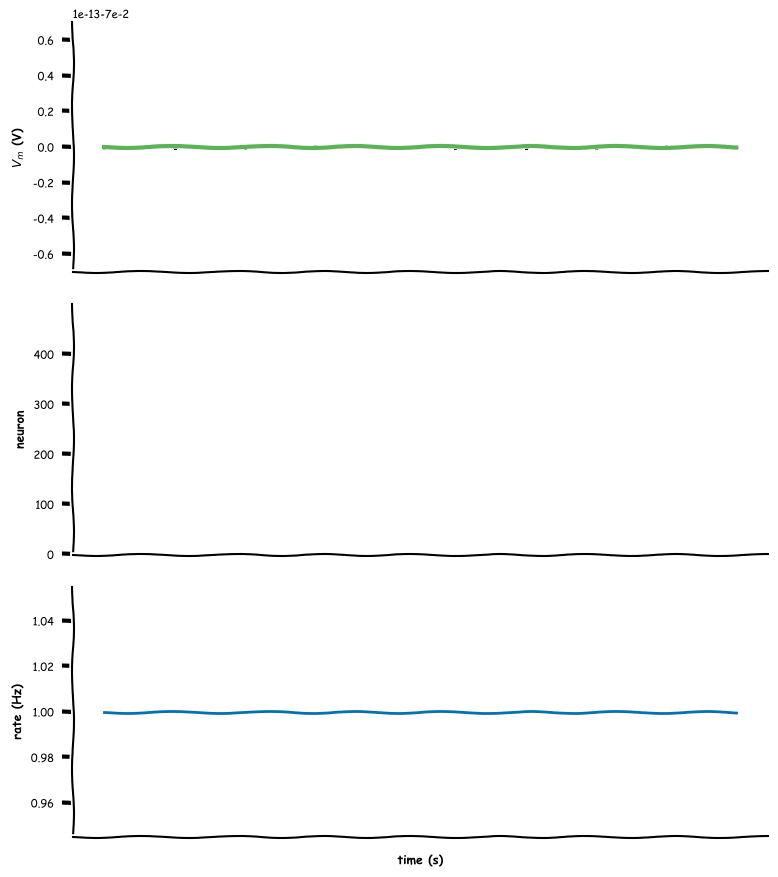

In [36]:
# Simulation class
class LIFNeurons:
    """
    Keeps track of membrane potential for multiple realizations of LIF neuron,
    and performs single step discrete time integration.
    """
    def __init__(self, n, t_ref_mu=0.01, t_ref_sigma=0.002,
               tau=20e-3, el=-60e-3, vr=-70e-3, vth=-50e-3, r=100e6):

        # Neuron count
        self.n = n

        # Neuron parameters
        self.tau = tau        # second
        self.el = el          # milivolt
        self.vr = vr          # milivolt
        self.vth = vth        # milivolt
        self.r = r            # ohm

        # Initializes refractory period distribution
        self.t_ref_mu = t_ref_mu
        self.t_ref_sigma = t_ref_sigma
        self.t_ref = self.t_ref_mu + self.t_ref_sigma * np.random.normal(size=self.n)
        self.t_ref[self.t_ref<0] = 0

        # State variables
        self.v = self.el * np.ones(self.n)
        self.spiked = self.v >= self.vth
        self.last_spike = -self.t_ref * np.ones([self.n])
        self.t = 0.
        self.steps = 0


    def ode_step(self, dt, i):
        """
        perform a single update step
        """

        # Update running time and steps
        self.t += dt
        self.steps += 1

        # One step of discrete time integration of dt
        self.v = self.v + dt / self.tau * (self.el - self.v + self.r * i)

        # Spike and clamp
        self.spiked = (self.v >= self.vth)
        self.v[self.spiked] = self.vr
        self.last_spike[self.spiked] = self.t
        clamped = (self.t_ref > self.t-self.last_spike)
        self.v[clamped] = self.vr

        self.last_spike[self.spiked] = self.t


t_max = 1
dt = 0.1
i_mean = 25e-11
# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# Initialize neurons
neurons = LIFNeurons(n)

# Loop over time steps
for step, t in enumerate(t_range):

  # Call ode_step method
  neurons.ode_step(dt, i[:,step])

  # Log v_n and spike history
  v_n[:,step] = neurons.v
  raster[neurons.spiked, step] = 1.

# Report running time and steps
print(f'Ran for {neurons.t:.3}s in {neurons.steps} steps.')

# Plot multiple realizations of Vm, spikes and mean spike rate
with plt.xkcd():
  plot_all(t_range, v_n, raster)

In [34]:
def plot_all(t_range, v, raster=None, spikes=None, spikes_mean=None):
  """
  Plots Time evolution for
  (1) multiple realizations of membrane potential
  (2) spikes
  (3) mean spike rate (optional)

  Args:
    t_range (numpy array of floats)
        range of time steps for the plots of shape (time steps)

    v (numpy array of floats)
        membrane potential values of shape (neurons, time steps)

    raster (numpy array of floats)
        spike raster of shape (neurons, time steps)

    spikes (dictionary of lists)
        list with spike times indexed by neuron number

    spikes_mean (numpy array of floats)
        Mean spike rate for spikes as dictionary

  Returns:
    Nothing.
  """

  v_mean = np.mean(v, axis=0)
  fig_w, fig_h = plt.rcParams['figure.figsize']
  plt.figure(figsize=(fig_w, 1.5 * fig_h))

  ax1 = plt.subplot(3, 1, 1)
  for j in range(n):
    plt.scatter(t_range, v[j], color="k", marker=".", alpha=0.01)
  plt.plot(t_range, v_mean, 'C1', alpha=0.8, linewidth=3)
  plt.xticks([])
  plt.ylabel(r'$V_m$ (V)')

  if raster is not None:
    plt.subplot(3, 1, 2)
    spikes_mean = np.mean(raster, axis=0)
    plt.imshow(raster, cmap='Greys', origin='lower', aspect='auto')

  else:
    plt.subplot(3, 1, 2, sharex=ax1)
    for j in range(n):
      times = np.array(spikes[j])
      plt.scatter(times, j * np.ones_like(times), color="r", marker=".", alpha=0.2)

  plt.xticks([])
  plt.ylabel('neuron')

  if spikes_mean is not None:
    plt.subplot(3, 1, 3, sharex=ax1)
    plt.plot(t_range, spikes_mean)
    plt.xlabel('time (s)')
    plt.ylabel('rate (Hz)')

  plt.tight_layout()
  plt.show()

Ran for 0.1s in 100 steps.


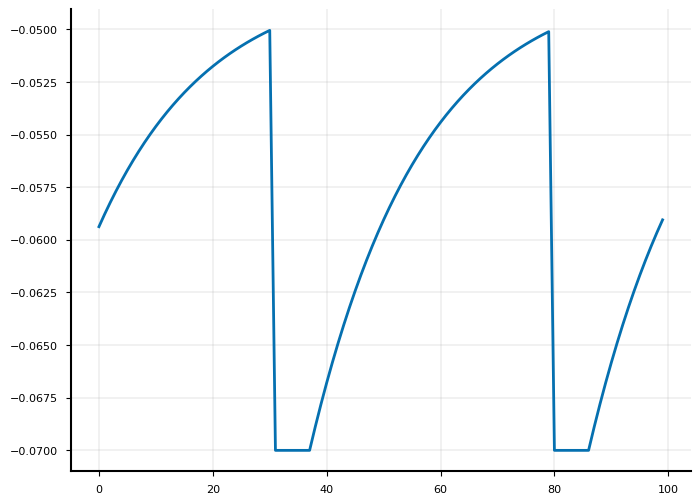

In [59]:
t_max = 0.1
dt = 0.001
i_mean = 25e-11/2
# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 1
v_n = np.ones([n, step_end])
i = i_mean #/7. * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# Initialize neurons
neurons = LIFNeurons(n)

# Loop over time steps
for step, t in enumerate(t_range):

  # Call ode_step method
  neurons.ode_step(dt, i)

  # Log v_n and spike history
  v_n[:,step] = neurons.v
  raster[neurons.spiked, step] = 1.

# Report running time and steps
print(f'Ran for {neurons.t:.3}s in {neurons.steps} steps.')

# Plot multiple realizations of Vm, spikes and mean spike rate
plt.figure();
plt.plot(v_n[0])